In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import torch
from PIL import Image

In [16]:
class LaticiferPatchTrain(Dataset):
    def __init__(
        self,
        feature_dirs,
        patch_size=(512, 512),
        patches_per_image=20,
        positive_ratio=0.8,
        dist_transform=False,
        fg_threshold=0.03,
        filenames=None,
        curriculum_level=0
    ):
        self.feature_dirs = feature_dirs
        self.patch_size = patch_size
        self.patches_per_image = patches_per_image
        self.positive_ratio = positive_ratio
        self.dist_transform = dist_transform
        self.fg_threshold = fg_threshold
        self.curriculum_level = curriculum_level  # NEW

        self.filenames = filenames if filenames is not None else sorted(os.listdir(self.feature_dirs['mask']))

        additional_targets = {
            key: 'image' for key in feature_dirs if key not in ['mask', 'enhanced', 'distance']
        }
        if dist_transform:
            additional_targets['distance'] = 'mask'

        self.transforms = A.Compose(
            [
                #A.HorizontalFlip(p=0.5),
                #A.VerticalFlip(p=0.5),
                #A.RandomRotate90(p=0.5),
                #A.ElasticTransform(alpha=150, sigma=5, p=0.3, border_mode=cv2.BORDER_REFLECT_101),
                #A.GridDistortion(p=0.2, border_mode=cv2.BORDER_REFLECT_101),
                #A.Normalize(mean=(0.5,) * len(feature_dirs), std=(0.5,) * len(feature_dirs)),
                ToTensorV2()
            ],
            additional_targets=additional_targets
        )

        self.samples = []
        for i in range(len(self.filenames)):
            self.samples.extend([i] * patches_per_image)

    def __len__(self):
        return len(self.samples)

    def _load_feature(self, dir_path, fname, key=None):
        if key == 'distance':
            fname = os.path.splitext(fname)[0] + '.pt'
            path = os.path.join(dir_path, fname)
            return torch.load(path, weights_only=True).squeeze(0).numpy()
        else:
            path = os.path.join(dir_path, fname)
            img = np.array(Image.open(path).convert("L")).astype(np.float32)
            return img

    def _random_patch_coords(self, H, W):
        ph, pw = self.patch_size
        #top = np.random.randint(0, H - ph + 1)
        #left = np.random.randint(0, W - pw + 1)
        top = H // 2
        left = W // 2
        return top, left

    def _find_positive_patch(self, mask):
        max_tries = 50
        H, W = mask.shape
        ph, pw = self.patch_size
        for _ in range(max_tries):
            top, left = self._random_patch_coords(H, W)
            patch = mask[top:top + ph, left:left + pw]
            if patch.sum() / patch.size >= self.fg_threshold:
                return top, left
        print("FAILED!")
        return self._random_patch_coords(H, W)

    def _apply_curriculum(self, mask):
        """Applies morphological dilation to the mask based on curriculum level."""
        if self.curriculum_level <= 0:
            return mask
        kernel = np.ones((3, 3), np.uint8)
        mask_dilated = cv2.dilate(mask.astype(np.uint8), kernel, iterations=self.curriculum_level)
        return mask_dilated.clip(0, 1)

    def __getitem__(self, idx):
        file_idx = self.samples[idx]
        fname = self.filenames[file_idx]

        mask = self._load_feature(self.feature_dirs['mask'], fname, key='mask') // 255
        mask = self._apply_curriculum(mask)  # NEW: Apply curriculum learning

        H, W = mask.shape

        choose_positive = np.random.rand() < self.positive_ratio
        if choose_positive:
            top, left = self._find_positive_patch(mask)
        else:
            top, left = self._random_patch_coords(H, W)

        features = {
            key: self._load_feature(path, fname, key=key)
            for key, path in self.feature_dirs.items()
            if key not in ['mask', 'distance']
        }

        cropped_features = {
            key: feat[top:top+self.patch_size[0], left:left+self.patch_size[1]]
            for key, feat in features.items()
        }

        mask_crop = mask[top:top+self.patch_size[0], left:left+self.patch_size[1]]

        if self.dist_transform:
            dist = self._load_feature(self.feature_dirs['distance'], fname, key='distance')
            dist_crop = dist[top:top+self.patch_size[0], left:left+self.patch_size[1]]
            cropped_features['distance'] = dist_crop

        augmented = self.transforms(
            image=cropped_features['enhanced'],
            mask=mask_crop,
            **{k: v for k, v in cropped_features.items() if k != 'enhanced'}
        )

        feature_tensors = [augmented['image']]
        for k in cropped_features:
            if k != 'enhanced' and k != 'distance':
                feat = augmented[k]
                if feat.ndim == 2:
                    feat = feat.unsqueeze(0)
                feature_tensors.append(feat)

        result = {
            'inputs': torch.cat(feature_tensors, dim=0),
            'masks': augmented['mask'].unsqueeze(0).float()
        }

        if self.dist_transform:
            result['dist_maps'] = augmented['distance'].unsqueeze(0).float()

        return result

Found 35 files.


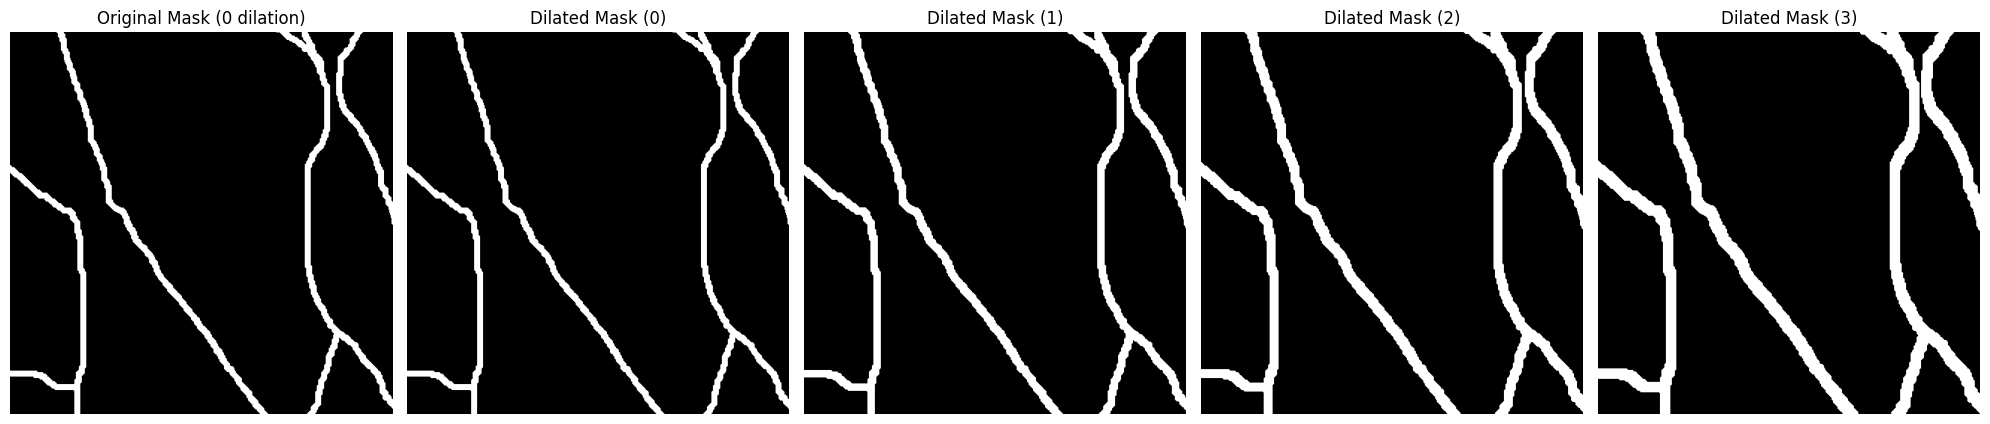

In [17]:
# Set dataset paths
feature_dirs = {
    'enhanced': 'datasets/laticifers/enhanced_images/',
    'mask': 'datasets/laticifers/masks/',
}

# List available image filenames
filenames = sorted(os.listdir(feature_dirs['mask']))
print(f"Found {len(filenames)} files.")

# Choose a sample file (change the index to test different files)
sample_idx = 0

# Patch extraction settings
patch_size = (512, 512)

# Curriculum levels to visualize
curriculum_levels = [0, 1, 2, 3]

# Plotting setup
fig, axes = plt.subplots(1, len(curriculum_levels) + 1, figsize=(4 * (len(curriculum_levels) + 1), 5))

# Load original mask (without dilation) for reference
dataset_original = LaticiferPatchTrain(
    feature_dirs=feature_dirs,
    patch_size=patch_size,
    patches_per_image=1,
    curriculum_level=0,
    filenames=[filenames[sample_idx]]
)

original_sample = dataset_original[0]
original_image = original_sample['inputs'][0].numpy()
original_mask = original_sample['masks'][0].numpy()

axes[0].imshow(original_mask, cmap='gray')
axes[0].set_title('Original Mask (0 dilation)')
axes[0].axis('off')

# Loop through curriculum levels
for i, level in enumerate(curriculum_levels):
    dataset = LaticiferPatchTrain(
        feature_dirs=feature_dirs,
        patch_size=patch_size,
        patches_per_image=1,
        curriculum_level=level,
        filenames=[filenames[sample_idx]]
    )

    sample = dataset[0]
    mask = sample['masks'][0].numpy()

    axes[i + 1].imshow(mask, cmap='gray')
    axes[i + 1].set_title(f'Dilated Mask ({level})')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

Found 35 files.


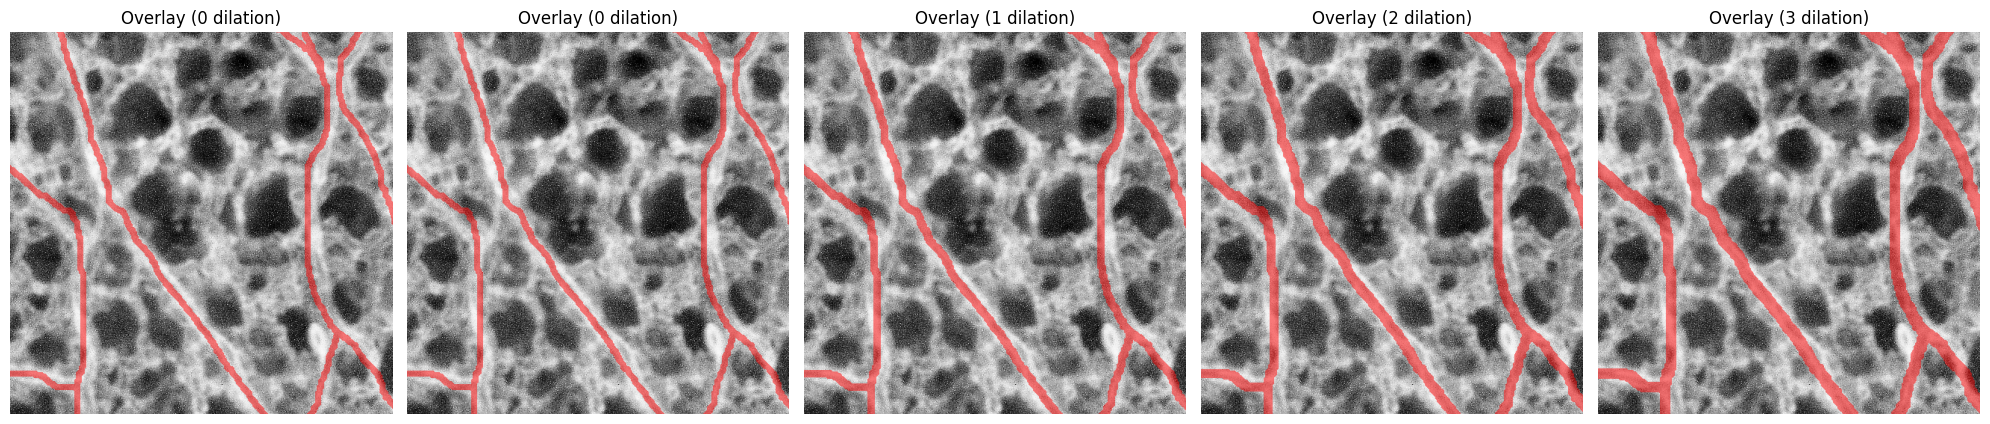

In [25]:
# Set dataset paths
feature_dirs = {
    'enhanced': 'datasets/laticifers/enhanced_images/',
    'mask': 'datasets/laticifers/masks/',
}

# List available image filenames
filenames = sorted(os.listdir(feature_dirs['mask']))
print(f"Found {len(filenames)} files.")

# Choose a sample file (change the index to test different files)
sample_idx = 0

# Patch extraction settings
patch_size = (512, 512)

# Curriculum levels to visualize
curriculum_levels = [0, 1, 2, 3]

# Plotting setup
fig, axes = plt.subplots(1, len(curriculum_levels) + 1, figsize=(4 * (len(curriculum_levels) + 1), 5))

def overlay_mask(image_gray, mask, color=(255, 0, 0), alpha=0.5):
    image_color = cv2.cvtColor(image_gray, cv2.COLOR_GRAY2RGB)
    mask_color = np.zeros_like(image_color)
    mask_color[:, :, 0] = color[0]
    mask_color[:, :, 1] = color[1]
    mask_color[:, :, 2] = color[2]

    mask_bool = mask > 127
    overlayed = np.where(mask_bool[..., None],
                         (1 - alpha) * image_color + alpha * mask_color,
                         image_color).astype(np.uint8)
    return overlayed


# Load original mask (without dilation)
dataset_original = LaticiferPatchTrain(
    feature_dirs=feature_dirs,
    patch_size=patch_size,
    patches_per_image=1,
    curriculum_level=0,
    filenames=[filenames[sample_idx]]
)

original_sample = dataset_original[0]
original_image = original_sample['inputs'][0].numpy()
original_mask = original_sample['masks'][0].numpy() * 255
overlay_img = overlay_mask((original_image * 255).astype(np.uint8), original_mask)

axes[0].imshow(overlay_img)
axes[0].set_title('Overlay (0 dilation)')
axes[0].axis('off')

# Loop through curriculum levels
for i, level in enumerate(curriculum_levels):
    dataset = LaticiferPatchTrain(
        feature_dirs=feature_dirs,
        patch_size=patch_size,
        patches_per_image=1,
        curriculum_level=level,
        filenames=[filenames[sample_idx]]
    )

    sample = dataset[0]
    image = sample['inputs'][0].numpy()
    mask = sample['masks'][0].numpy() * 255
    overlay_img = overlay_mask((image * 255).astype(np.uint8), mask)

    axes[i + 1].imshow(overlay_img)
    axes[i + 1].set_title(f'Overlay ({level} dilation)')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()
